In [3]:
# Importanto pacotes para trabalhar com Perceptron 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
# Separação dos dados de teste e treino
from sklearn.model_selection import train_test_split 
# Pacotes para averiguar a acuracia do treinamento 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Manipulação dos dados
import numpy as np
import pandas as pd

# Tratamento de Base de Dados

Todas as bases de dados precisam ser editadas, pois por ventura sempre há dados não preenchidos e\ou incopativeis, no qual o Python não consegue ler. Sendo assim, logo a baixo iremos editar os dados da planilha dos sobreviventes do titanic para posteriormente treinar o perceptron. 

In [4]:
# Os arquivos CSV são arquivos em modelo de texto editavél, em arquivo em excel pode ser salvo em CSV pois ele é muito útil para integração dos dados. 
train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

dropped_test = test_data.dropna()  # A dropna deleta as linhas e os campos que estiverem vazios.

Há varias colunas na planilha do titanic, sendo que algumas não uteis para treinar a rede, sendo assim abaixo iremos excluir as que não vamos usar. 

In [5]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
# O 'axis' exclui a coluna inteira e o 'inplace' "confirma" a exclusão. 

A rede neural, não pode trabalhar com elementos que não sejam números, no dados do titanic há sexo feminino e masculino, sendo assim eles precisam ser convertidos em número representativo de preferencia binário. Para que não seja agregado "pesos" diferentes. Por isso, usa-se o 'labelencoder'.

In [6]:
le = LabelEncoder()
train_data["Sex"] = le.fit_transform(train_data["Sex"])
test_data["Sex"] = le.fit_transform(test_data["Sex"])

Para transformar o código superior em número binário, vamos utilizar o 'oneHotEncoder'.

In [7]:
enc = OneHotEncoder(handle_unknown='ignore')

one_hot_encond_temp = pd.DataFrame(enc.fit_transform(train_data[['Embarked']]).toarray())
train_data = train_data.iloc[: , :-1]
pd.concat([train_data, one_hot_encond_temp], axis=1, ignore_index=False)

one_hot_encond_temp = pd.DataFrame(enc.fit_transform(test_data[['Embarked']]).toarray())
test_data = test_data.iloc[: , :-1]
pd.concat([test_data, one_hot_encond_temp], axis=1, ignore_index=False)

,Pclass,Sex,Age,SibSp,Parch,Fare,0,1,2
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,0,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,0,22.0,1,1,12.2875,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,0.0,0.0,1.0
414,1,0,39.0,0,0,108.9000,1.0,0.0,0.0
415,3,1,38.5,0,0,7.2500,0.0,0.0,1.0
416,3,1,NaN,0,0,8.0500,0.0,0.0,1.0


In [9]:
# Para remover os "NaN"
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [10]:
# O 'x' é a informação de todos os passageiros e o 'y', se o passageiro sobreviveu ou não.

XTrain = train_data.iloc[: , 1 : ]
yTrain = train_data.iloc[: , 0]

XTest = test_data

XTrain

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250
886,2,1,27.0,0,0,13.0000
887,1,0,19.0,0,0,30.0000
889,1,1,26.0,0,0,30.0000


Para a rede neural funcionar bem é importante que todas as colunas sejam caracterizadas em números entre -1 e +1. Para isso, vamos utilizar o 'StandardScaler'. Primeiro, vamos treinar usando a base de teste e depois vamos excutar com as bases de treino e teste.

In [11]:
sc = StandardScaler() 
sc.fit(XTrain) 

XTrain = sc.transform(XTrain.values) 
XTest = sc.transform(XTest.values)  

XTrain

array([[ 0.91123237,  0.75905134, -0.53037664,  0.52457013, -0.50589515,
        -0.51897787],
       [-1.47636364, -1.31743394,  0.57183099,  0.52457013, -0.50589515,
         0.69189675],
       [ 0.91123237, -1.31743394, -0.25482473, -0.55170307, -0.50589515,
        -0.50621356],
       ...,
       [-1.47636364, -1.31743394, -0.73704057, -0.55170307, -0.50589515,
        -0.08877362],
       [-1.47636364,  0.75905134, -0.25482473, -0.55170307, -0.50589515,
        -0.08877362],
       [ 0.91123237,  0.75905134,  0.15850313, -0.55170307, -0.50589515,
        -0.50952283]])

# Rede Neural

O Perceptron que iremos usar abaixo usa um metodo do gradiente estocástico, ou seja, os ajustes dos neurônios aconteceram de modo aleatório. Para que não seja necessário em cada "epoc" usar todo o conjunto de treinamento da rede neural para justes os pesos dos neurônios. Exemplo, o perceptron vai sortear alguns passageiros para ajudar os pesos em uma "epoc" e no próximo ajuste ele vai sortear outros passageiros. Dessa forma, a rede neural se ajusta muito melhor quando há entrada de novos dados.

In [12]:
ppn = Perceptron(max_iter=1000, eta0=0.1, random_state=0) 
#usa SGD (comentar que atualiza os w para cada amostra e "sorteia" as amostras, permitindo melhor convergência na busca pelo minimo global; fora que permite online learning)
#o batch gd (igual do vídeo passado) é bom para bases pequenas, mas ruim para bases grandes principalmente devido ao estouro de memória, fora que converge mais rápido
#minibatch tem características hibridas

ppn.fit(XTrain, yTrain)

Perceptron(eta0=0.1)

O metodo 'predict' vai buscar os passageiros que sobreviveram 

In [13]:
yPred = ppn.predict(XTest)

In [14]:
y_test = pd.read_csv("test_y.csv")
y_test.drop(dropped_test['PassengerId'].index, inplace=True)
y_test = y_test["Survived"].values

In [18]:
yPred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,

In [19]:
y_test

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,

Para avaliar o indice de acerto da rede neural vamos usar o 'confusion_matrix' e depois o 'plot' que traz em forma de representação gráfica.

In [20]:
confusion_matrix(y_test, yPred)

array([[151,  72],
       [ 68,  40]], dtype=int64)

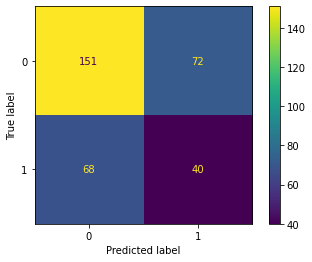

In [21]:
plot_confusion_matrix(ppn, XTest, y_test) 

Em azul está representado onde a rede errou, onde tem 0 representa o número de sobrevivente que a rede acertou e onde tem roxo é o número de óbtos e a rede acertou. 


In [22]:
accuracy_score(y_test, yPred)

0.5770392749244713

In [23]:
ppn.score(XTest, y_test)

0.5770392749244713

# Links Extras

* https://www.youtube.com/playlist?list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO
* https://www.youtube.com/watch?v=aircAruvnKk
* https://www.youtube.com/watch?v=c6NBkkKNZXw&list=PLxt59R_fWVzT9bDxA76AHm3ig0Gg9S3So&index=5
* https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
* https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.Perceptron.html
* https://chrisalbon.com/machine_learning/basics/perceptron_in_scikit-learn/